# Flex2D

This notebook is a simple Python implementation of the Flex2D application that can be downloaded here: http://www.ux.uis.no/~nestor/work/programs.html

> The displacement profile of the surface of the earth under crustal loads (e.g. mountain chains) can be well reproduced by an elastic flexural model. In this model, the uppermost layer of the earth responds to crustal loads as an elastic beam floating in a weaker, fluid-like foundation (i.e. the astenospheric mantle, Turcotte and Schubert, 1982).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Equations

The following functions implement the elastic flexural model for an infinite elastic beam with constant thickness.

Much of the documentation for the equations was taken from the Help section of the Flex2D application.

Use the flexural rigidity ($D$) to express the 'strength' of the elastic lithosphere (i.e. elastic beam):

$$
D = \frac{E\:T^{3}}{12(1-\nu^{2})}
$$

where $E$ is Young's modulus, $\nu$ is Poisson ratio, and $T$ is the thickness of the elastic lithosphere.

In [2]:
def get_D(E, nu, T):
    D = E * (T**3) / (12*(1-nu**2))
    return D

Invent a term $D_{(\alpha,x)}$:

$$
D_{(\alpha,x)} = \exp\left(\frac{-x}{\alpha}\right)\cos\left(\frac{x}{\alpha}\right)
$$

where $x$ is the horizontal coordinate and $\alpha$ is a length parameter given by:

$$
\alpha = \left(\frac{4D}{\rho_{f}g}\right)^{1/4}
$$

where $\rho_{f}$ is the density of the foundation. This is the difference between the density of the mantle and the density of the material filling the basin. $g$ is gravity.

In [3]:
def get_D_alpha_x(x, alpha):
    D_alpha_x = np.exp(-x/alpha) * np.cos(x/alpha)
    return D_alpha_x

def get_alpha(D, rho_f):
    g = 9.8 #m/s**2
    alpha = ((4*D)/(rho_f*g))**(1/4)
    return alpha

The deflection ($u$) at any point $c$ along the elastic lithosphere (i.e. elastic beam) is equal to:

If point $c$ is under the load column:

$$
u = \left(\frac{q}{2k}\right)(2-D_{(\alpha,a)}-D_{(\alpha,b)})
$$

If point $c$ is to the left of the load column:

$$
u = \left(\frac{q}{2k}\right)(D_{(\alpha,a)}-D_{(\alpha,b)})
$$

If point $c$ is to the right of the load column:

$$
u = \left(\frac{-q}{2k}\right)(D_{(\alpha,a)}-D_{(\alpha,b)})
$$

where $q/k = h(\rho/\rho_{f})$, $h$ is the load height, and $\rho$ is the load density. $a$ and $b$ are measured as absolute values of distances from point $c$ to the left and right borders of the load column, respectively.

In [4]:
def get_deflection_under(h, rho, rho_f, D_alpha_a, D_alpha_b):
    q_k = h * (rho/rho_f)
    u = (0.5*q_k) * (2-D_alpha_a-D_alpha_b)
    return u

def get_deflection_left(h, rho, rho_f, D_alpha_a, D_alpha_b):
    q_k = h * (rho/rho_f)
    u = (0.5*q_k) * (D_alpha_a-D_alpha_b)
    return u

def get_deflection_right(h, rho, rho_f, D_alpha_a, D_alpha_b):
    q_k = h * (rho/rho_f)
    u = (-0.5*q_k) * (D_alpha_a-D_alpha_b)
    return u

We can put all of the equations above together to calculate the deflection profile for a single load:

In [5]:
def get_single_deflection(x, h, rho, load_x_left, load_x_right, E, nu, T, rho_f):
    """
    Calculate the deflection profile for a single load.
    
    Parameters
    ----------
    x : array_like
        x values at which to calculate the deflection.
        Units = m
        
    h : scalar
        The height of the load.
        Units = m
        
    rho : scalar
        The density of the load.
        Units = kg/m**3
        
    load_x_left : scalar
        The x coordinate of the left edge of the load.
        Units = m
        
    load_x_right : scalar
        The x coordinate of the right edge of the load.
        Units = m
        
    E : scalar
        Young's modulus of the beam.
        Units = Pa (or kg/m**-1/s**-2)
        
    nu : scalar
        Poisson ratio of the beam.
        Units = unitless
        
    T : scalar
        Thickness of the beam.
        Units = m
        
    rho_f : scalar
        The density of the foundation.
        Units = kg/m**3
        
    Returns
    -------
    deflection : array
        The deflection of the beam.
    """
    D = get_D(E, nu, T)
    alpha = get_alpha(D, rho_f)
    
    deflection = np.zeros(len(x))
    for i in range(len(x)):
        if x[i] < load_x_left:
            D_alpha_a = get_D_alpha_x(load_x_left-x[i], alpha)
            D_alpha_b = get_D_alpha_x(load_x_right-x[i], alpha)
            u = get_deflection_left(h, rho, rho_f, D_alpha_a, D_alpha_b)
        elif x[i] > load_x_right:
            D_alpha_a = get_D_alpha_x(x[i]-load_x_left, alpha)
            D_alpha_b = get_D_alpha_x(x[i]-load_x_right, alpha)
            u = get_deflection_right(h, rho, rho_f, D_alpha_a, D_alpha_b)
        else:
            D_alpha_a = get_D_alpha_x(x[i]-load_x_left, alpha)
            D_alpha_b = get_D_alpha_x(load_x_right-x[i], alpha)
            u = get_deflection_under(h, rho, rho_f, D_alpha_a, D_alpha_b)
        deflection[i] = u
        
    return deflection

If there is more than one load, the total displacement profile is computed by adding the displacement profiles of the individual load columns:

In [6]:
def get_total_deflection(x, h, rho, load_x_left, load_x_right, E, nu, T, rho_f):
    """
    Calculate the deflection profile for multiple loads.
    
    Parameters
    ----------
    x : array_like
        x values at which to calculate the deflection.
        Units = m
        
    h : array_like
        The height of the loads.
        Units = m
        
    rho : array_like
        The density of the loads.
        Units = kg/m**3
        
    load_x_left : array_like
        The x coordinate of the left edge of the loads.
        Units = m
        
    load_x_right : array_like
        The x coordinate of the right edge of the loads.
        Units = m
        
    E : scalar
        Young's modulus of the beam.
        Units = Pa (or kg/m**-1/s**-2)
        
    nu : scalar
        Poisson ratio of the beam.
        Units = unitless
        
    T : scalar
        Thickness of the beam.
        Units = m
        
    rho_f : scalar
        The density of the foundation.
        Units = kg/m**3
        
    Returns
    -------
    deflection : array
        The deflection of the beam.
    """
    deflections = np.zeros((len(x), len(load_x_left)))
    
    for i in range(len(load_x_left)):
        deflection = get_single_deflection(x, h[i], rho[i], load_x_left[i], load_x_right[i], E, nu, T, rho_f)
        deflections[:,i] = deflection
    total_deflection = np.sum(deflections, axis=1)
    
    return total_deflection

## Playground

Here we can implement the elastic flexural model for different beam and load properties, then plot the results.

Edit values within code cells with <font color='red'>**red**</font> text to change the properties of the beam and load(s).

### Set beam properties

<font color='red'>**Edit these values:**</font>

In [7]:
# Young's modulus: Pa
E = 70 * 1e9

# Poisson's ratio: unitless
nu = 0.25

# foundation density: kg/m**3
rho_f = 3300

# thickness: m
T = 30 * 1e3

### Set load properties

<font color='red'>**Edit these values:**</font>

(One value for each load you would like to plot.)

In [8]:
# x coordinates of the left edges: m
load_x_left  = np.array([100, 120, 140]) * 1e3

# x coordinates of the right edges: m
load_x_right = np.array([120, 140, 160]) * 1e3

# heights: m
h = np.array([3000, 3500, 3000])

# densities: kg/m**3
rho = np.array([2700, 2700, 2700])

Compile the load properties into a dataframe:

In [9]:
loads = pd.DataFrame({'x_left':load_x_left,
                      'x_right':load_x_right,
                      'h':h,
                      'rho':rho})
loads

,x_left,x_right,h,rho
0,100000.0,120000.0,3000,2700
1,120000.0,140000.0,3500,2700
2,140000.0,160000.0,3000,2700


### Plot

<font color='red'>**Edit these values:**</font>

In [10]:
# the start and end of the x values at which to calculate the deflection: m
x_start = 0
x_end = 1000 * 1e3

# if you want the x and y axes to have the same scale, set this to True
to_scale = False

Make the plot:

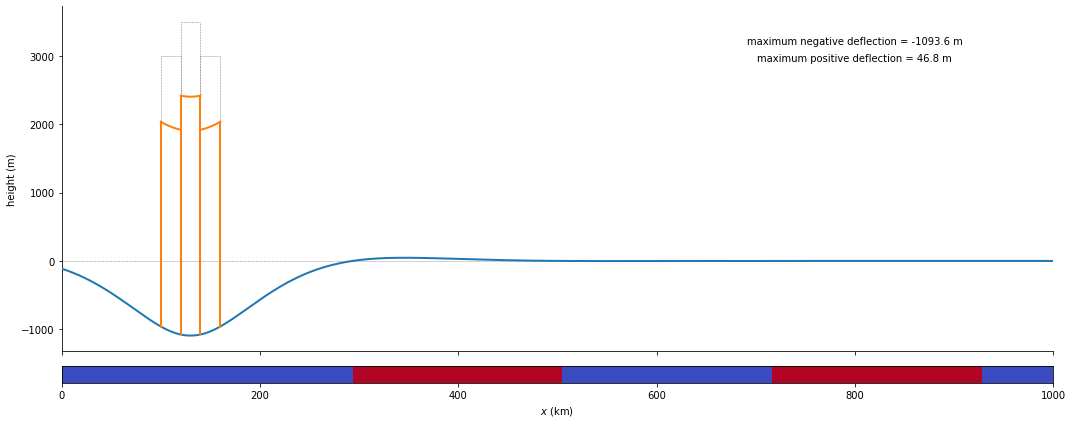

In [11]:
# linearly space the x values at which to calculate the deflection
n_x = 1000
x = np.linspace(x_start, x_end, n_x)

# calculate the deflection
deflection = get_total_deflection(x,
                                  loads['h'], loads['rho'], loads['x_left'], loads['x_right'],
                                  E, nu, T, rho_f)

# set up the figure
# note: nrows and ncols sets the number of subplots in the figure
# note: sharex makes the x-axis shared between all subplots
# note: figsize set the (width,height) of the figure canvas in inches
# note: gridspec_kw sets the height ratios of subplots (among other things)
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=False, figsize=(15,6), gridspec_kw={'height_ratios':[20,1]})

# plot the deflection
# note: we plot the negative deflection to show the profile of the surface
# note: zorder sets the plotting order (higher numbers will plot on top)
ax[0].plot(x, -deflection, color='C0', zorder=99, linewidth=2)

# plot the undeflected surface
# note: zorder sets the plotting order (lower numbers will plot on bottom)
ax[0].axhline(0, ls='--', c='C7', zorder=-99, linewidth=0.5)

# iterate through the loads
for i in range(len(loads)):
    
    # get the heights of the base of the deflected loads
    base_height_left = -np.interp(load_x_left[i], x, deflection)
    base_height_right = -np.interp(load_x_right[i], x, deflection)
    
    # get the heights of the top of the deflected loads
    top_height_left = base_height_left + h[i]
    top_height_right = base_height_right + h[i]
    
    # plot the vertical lines of the deflected loads
    ax[0].plot([load_x_left[i], load_x_left[i]],
               [base_height_left, top_height_left], c='C1', zorder=99, linewidth=2)
    ax[0].plot([load_x_right[i], load_x_right[i]],
               [base_height_right, top_height_right], c='C1', zorder=99, linewidth=2)
    
    # plot the top of the deflected loads
    load_top_x = np.linspace(load_x_left[i], load_x_right[i])
    load_top_y = -np.interp(load_top_x, x, deflection) + h[i]
    ax[0].plot(load_top_x, load_top_y, c='C1', zorder=99, linewidth=2)
    
    # plot the undeflected loads
    ax[0].plot([load_x_left[i], load_x_left[i]],
               [0, h[i]], c='C7', ls='--', zorder=-99, linewidth=0.5)
    ax[0].plot([load_x_right[i], load_x_right[i]],
               [0, h[i]], c='C7', ls='--', zorder=-99, linewidth=0.5)
    ax[0].plot([load_x_left[i], load_x_right[i]],
               [h[i], h[i]], c='C7', ls='--', zorder=-99, linewidth=0.5)
    
# scale the axis if set
if to_scale:
    ax[0].axis('equal')
    
# prettify
ax[0].set_ylabel('height (m)')
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].set_xlim(x_start, x_end)
ax[0].set_xticklabels([])

# find where the deflection is <0 and >0
deflection_binary = np.zeros_like(deflection)
deflection_binary[deflection>=0] = 1

# plot this binary mask
ax[1].pcolormesh(np.reshape(deflection_binary, (1,n_x)), cmap='coolwarm_r')

# prettify
ax0_xticks = ax[0].get_xticks()
ax[1].set_xticks(np.linspace(0, n_x, len(ax0_xticks)))
ax[1].set_xticklabels((ax0_xticks/1000).astype(np.int))
ax[1].set_ylim(0,1)
ax[1].set_yticks([])
ax[1].set_xlabel('$x$ (km)')

# print some values
ax[0].text(0.8, 0.90, 'maximum negative deflection = {} m'.format(-np.max(deflection).round(1)),
           horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes)
ax[0].text(0.8, 0.85, 'maximum positive deflection = {} m'.format(-np.min(deflection).round(1)),
           horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes)

fig.tight_layout()
plt.show(fig)

Note that in the lower binary colorbar, blue represents areas where the surface is deflected below the original horizontal surface, and red represents areas where the surface is deflected above the original horizontal surface.